In [2]:
import pandas as pd 
import numpy as np
import re
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn import metrics
from sklearn import decomposition
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/slavaspirin/Toronto-housing-price-prediction/master/houses.csv")
original_data = df.copy()
df.head()

,index,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code
0,0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,2 + 1 beds,2 baths,800–899 sq. ft.,1 parking,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76
1,1,"2 Cabot Crt, Toronto (W4502992) | Zoocasa",885000,898000,3 beds,2 baths,N/A sq. ft.,6 parking,Fantastic Opportunity To Live Within The Histo...,W4502992,Semi-Detached,https://www.zoocasa.com/toronto-on-real-estate...,"2 Cabot Crt, Toronto , Ontario, Canada",43.646982,-79.530356,Islington-City Centre West,52787,14
2,2,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1 beds,1 baths,500–599 sq. ft.,no parking,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104
3,3,"514 - 65 East Liberty St, Toronto (C4515763) |...",665000,600000,1 + 1 beds,1 baths,600–699 sq. ft.,1 parking,Rare Loft-Like Condo In Liberty Village W/ 18'...,C4515763,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"65 East Liberty St, Toronto , Ontario, Canada",43.638399,-79.414448,Niagara,70623,82
4,4,"61 Twelfth St, Toronto (W4519375) | Zoocasa",825513,839000,2 beds,2 baths,N/A sq. ft.,1 parking,Location! Location! Location. Your Cottage In ...,W4519375,Detached,https://www.zoocasa.com/toronto-on-real-estate...,"61 Twelfth St, Toronto , Ontario, Canada",43.597096,-79.509612,New Toronto,44101,18


In [4]:
def cleansing_function(df):
    df = df.copy()
    abnType = df['type'].unique()[5] ## taking out the abnormal hosue type
    df = df[df['type']!= abnType]
    ## checking all the cities that are in the data

    '''
    we are going to split the data using the "," and then split based on teh space and get the city from each one,

    This will be added to a new column called "city"
    '''
    df["city"] = df["full_address"].apply(lambda x: x.split(",")[1].split(" ")[1].upper())
    ## now we will exclude the only row with the value "OUT" as city

    df = df[df["city"] != "OUT"]
    ## now let's clean the bedrooms column

    df["bedrooms"] = df["bedrooms"].apply(lambda x: ' '.join(x.split(" ")))

    for i,n in enumerate(df["bedrooms"]):
        df["bedrooms"].iloc[i] = max([int(s) for s in n.split() if s.isdigit()])
    ## now let's clean the bathrooms column

    df["bathrooms"] = df["bathrooms"].apply(lambda x: int(''.join(x.lower()).replace("baths", '')))
    ## now let's clean the parking column
    df["parking"] = df["parking"].apply(lambda x:    str(x).replace('no parking', '0')  )
    df["parking"] = df["parking"].apply(lambda x:    int(str(x).replace(' parking', '')  ))
    
    ## cleaning the type column

    df["type"] = df["type"].str.upper()

    for i,t in enumerate(df["type"]):
        if "APT" in t:
            df["type"].iloc[i] = "APT"
        elif "CONDO" in t:
            df["type"].iloc[i] = "CONDO"
        elif "DETACHED" in t:
            df["type"].iloc[i] = "DETACHED_HOUSE"
        elif "TWNHOUSE" in t:
            df["type"].iloc[i] = "TWNHOUSE"
    df["type"] = df["type"][df["type"] != "COTTAGE"][df["type"] != "FOURPLEX"]
    
    ## counting out rows that have bathrooms more than bedrooms
    df = df.query("bedrooms >= bathrooms")
    
    ## cleaning the sqft column and applying the average on each value
    sqft = df["sqft"].str.split(" ", 1).apply(lambda x: x[0])
    sqft.replace({"N/A": "0-0"}, inplace=True)
    sqft = sqft.apply(lambda x: re.split('–|-',x))

    sqft = sqft.apply(lambda x: min(int(x[0]) , int(x[1])))
    sqft.replace({0: np.nan}, inplace=True)
    df["sqft"] = sqft
    
    frames = []
    for room in list(set(df['bedrooms'])):
        df_rooms = df[df['bedrooms']== room]
        df_rooms['sqft'].fillna(df_rooms['sqft'].min(),inplace = True)
        frames.append(df_rooms)
    final_df = pd.concat(frames)
    final_df = final_df.reset_index().drop(columns=['index', 'level_0'])
    final_df["sqft"] = final_df["sqft"].round()
    df = final_df
    return df


In [5]:
df = cleansing_function(df)
df.shape

(13310, 18)

In [6]:
# compute the pair wise correlation for all columns for feature extraction
correlation_matrix = df.corr().round(2)
correlation_matrix[correlation_matrix["final_price"] > 0].sort_values(by=["final_price"], ascending = False)

,final_price,list_price,bathrooms,sqft,parking,lat,long,mean_district_income,district_code
final_price,1.00,0.99,0.61,0.42,0.07,-0.13,-0.04,0.48,0.00
list_price,0.99,1.00,0.62,0.43,0.08,-0.11,-0.04,0.48,-0.01
bathrooms,0.61,0.62,1.00,0.55,0.10,0.20,0.05,0.07,0.05
mean_district_income,0.48,0.48,0.07,0.12,-0.02,-0.31,-0.08,1.00,-0.03
sqft,0.42,0.43,0.55,1.00,0.04,0.11,0.00,0.12,0.00
parking,0.07,0.08,0.10,0.04,1.00,0.06,-0.00,-0.02,-0.01


In [7]:
## fearures that will be used in this machine learing model, along with our target will be to find the final_price :

df[["bedrooms", "bathrooms", "parking", "long", "lat", "sqft", "final_price"]]

,bedrooms,bathrooms,parking,long,lat,sqft,final_price
0,1,1,0,-79.397498,43.708472,500.0,550000
1,1,1,1,-79.414448,43.638399,600.0,665000
2,1,1,1,-79.220229,43.805327,600.0,269900
3,1,1,1,-79.283388,43.769495,700.0,325000
4,1,1,1,-79.453072,43.714543,600.0,478000
...,...,...,...,...,...,...,...
13305,9,9,1,-79.502234,43.765282,2500.0,1080000
13306,9,8,2,-79.497067,43.768556,2000.0,810000
13307,9,5,2,-79.496027,43.766184,2500.0,1098000
13308,9,8,7,-79.439226,43.714476,2000.0,2125000


In [8]:
## our target
y = df[["final_price"]]

In [9]:
data_features = ["bedrooms", "bathrooms", "parking", "long", "lat"]

In [10]:
## features
x = df[data_features]

In [11]:
x.describe().round(decimals=2)

,bathrooms,parking,long,lat
count,13310.00,13310.00,13310.00,13310.00
mean,1.92,1.61,-79.39,43.70
std,0.87,5.30,0.10,0.06
min,1.00,0.00,-79.62,43.59
25%,1.00,1.00,-79.46,43.65
50%,2.00,1.00,-79.40,43.69
75%,2.00,2.00,-79.33,43.76
max,9.00,367.00,-79.12,43.84


In [12]:
x.isna().sum()

bedrooms     0
bathrooms    0
parking      0
long         0
lat          0
dtype: int64

In [13]:
# do the normalization on the data for more easier converagence

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)
X

,0,1,2,3,4
0,0.0,0.000,0.000000,0.447856,0.477075
1,0.0,0.000,0.002725,0.413626,0.197145
2,0.0,0.000,0.002725,0.805854,0.863998
3,0.0,0.000,0.002725,0.678303,0.720852
4,0.0,0.000,0.002725,0.335624,0.501328
...,...,...,...,...,...
13305,1.0,1.000,0.002725,0.236341,0.704021
13306,1.0,0.875,0.005450,0.246777,0.717103
13307,1.0,0.500,0.005450,0.248877,0.707627
13308,1.0,0.875,0.019074,0.363587,0.501062


In [14]:
# do the normalization on the data for more easier converagence

min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler.fit_transform(y)
Y = pd.DataFrame(y_scaled)
Y

,0
0,0.073315
1,0.092176
2,0.027374
3,0.036411
4,0.061506
...,...
13305,0.160243
13306,0.115959
13307,0.163195
13308,0.331639


In [15]:
'''StandardScaler is used to remove the outliners and scale the data by 
making the mean of the data 0 and standard deviation as 1.
So we are creating an object std_scl to use standardScaler
'''
std_slc = StandardScaler()

In [16]:
'''We are also using Principal Component Analysis(PCA) which will reduce the dimension 
of features by creating new features which have most of the varience of the original data
'''
pca = decomposition.PCA()

In [17]:
'''
Here, we are using Decision Tree Regressor as a Machine Learning model to use GridSearchCV.
So we have created an object dec_tree
'''

dtreeReg = tree.DecisionTreeRegressor()

In [18]:
'''Using Pipeline for GridSearchCV
Pipeline will helps us by passing modules one by one through GridSearchCV for which 
we want to get the best parameters.
So we are making an object pipe to create a pipeline for all the three objects std_scl, pca and dtreeReg.
'''

pipe = Pipeline(steps=[("std_slc", std_slc),
                           ("pca", pca),
                           ("dtreeReg", dtreeReg)])

Now we have to define the parameters that we want to optimise for these three objects.
StandardScaler doesnot requires any parameters to be optimised by GridSearchCV.
Principal Component Analysis requires a parameter "n_components" to be optimised. "n_components" signifies the number of components to keep after reducing the dimension.

In [19]:
n_components = list(range(1,X.shape[1]+1,1))

DecisionTreeClassifier requires two parameters "friedman_mse" and "mse" to be optimised by GridSearchCV. So we have set these two parameters as a list of values form which GridSearchCV will select the best value of parameter.


In [20]:
criterion = ["friedman_mse", "mse"]
max_depth = [4,6,8,10]

In [21]:
##Now we are creating a dictionary to set all the parameters options for different objects.

parameters = dict(pca__n_components=n_components,
                      dtreeReg__criterion=criterion,
                      dtreeReg__max_depth=max_depth)

Using GridSearchCV and Printing Results

Before using GridSearchCV, lets have a look on the important parameters.

estimator: In this we have to pass the models or functions on which we want to use GridSearchCV
param_grid: Dictionary or list of parameters of models or function in which GridSearchCV have to select the best.
Scoring: It is used as a evaluating metric for the model performance to decide the best hyperparameters, if not especified then it uses estimator score.
Making an object clf_GS for GridSearchCV and fitting the dataset i.e X and y


In [22]:
clf = GridSearchCV(pipe, parameters)
clf.fit(X, Y)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std_slc',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('dtreeReg',
                                        DecisionTreeRegressor(ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max

In [23]:
#Now we are using print statements to print the results. It will give the values of hyperparameters as a result


print("Best Number Of Components:", clf.best_estimator_.get_params()["pca__n_components"]) ## this will give me my best number of components to be used
print(); print(clf.best_estimator_.get_params()["dtreeReg"]) # this will give me the best params to be used

# use Cross Validation to evaluate the model

CV_Result = cross_val_score(clf, X, Y, cv=3, n_jobs=-1, scoring="r2") 
# cv =3 means to split the data into three parts and train on two and test on one
# b-jobs =-1 -- maximum number of paraller computation that you can do
# r2 this is the method used to know how much variation your model is caputring
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Number Of Components: 4

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

[-1.35211271  0.53387909  0.05212717]

-0.25536881645992976

0.800065247098112


In [42]:

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
# data_features = ["bedrooms", "bathrooms", "parking", "long", "lat"]
# X = df[data_features]
train_X, val_X, train_y, val_y = train_test_split(X, Y,test_size=0.2, random_state = 3)
print(train_X.shape)
print(val_X.shape)
print(train_y.shape)
print(val_y.shape)
# Define model
DT_model = DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
# Fit model
DT_model.fit(train_X, train_y)

# get predicted prices on validation data
val_predictions = DT_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

(10648, 5)
(2662, 5)
(10648, 1)
(2662, 1)
0.022142455358734808


In [43]:
# print the top few validation predictions
print(val_predictions[0:5])
# print the top few actual prices from validation data
print(val_y.head())

[0.10837616 0.04075741 0.10662819 0.07661429 0.19440361]
              0
8541   0.076267
2262   0.042152
6705   0.055601
2061   0.068558
10197  0.175824


In [44]:
## performance of the model. Give the R2 score

from sklearn.metrics import r2_score

r2_score(val_y, val_predictions)

0.7412417205177628

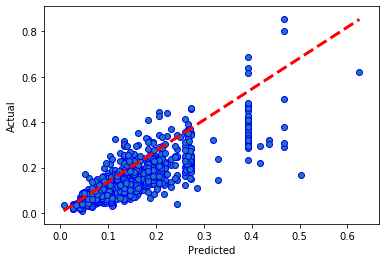

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(val_predictions, val_y, edgecolors=(0, 0, 1))
ax.plot([val_predictions.min(), val_predictions.max()], [val_y.min(), val_y.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [47]:
# ["bedrooms", "bathrooms", "parking", "long", "lat"]
# test = pd.DataFrame.from_dict(pd.Series([3, 2, 1, 43.661896, -79.385748]), columns=["bedrooms", "bathrooms", "parking", "long", "lat"])
#
test = pd.DataFrame.from_dict({
    "bedrooms":[3],
    "bathrooms":[2],
    "parking":[1],
    "long":[43.661896],
    "lat":[-79.385748]
})

# DT_model.predict(test)
# print the top few validation predictions
print(val_predictions[0:5])
# print the top few actual prices from validation data
print(val_y.head())


[0.10837616 0.04075741 0.10662819 0.07661429 0.19440361]
              0
8541   0.076267
2262   0.042152
6705   0.055601
2061   0.068558
10197  0.175824
